# Sin Wave 

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Let's create a sine wave

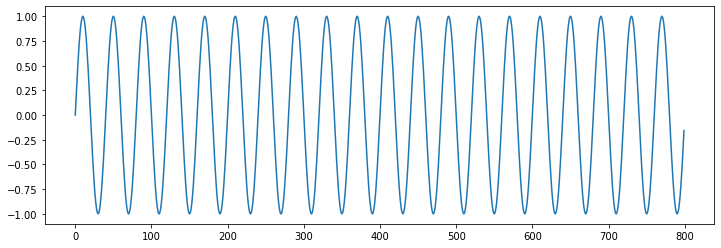

In [2]:
#let t = 1 to 800
#f = 1/40 frequency
t = torch.linspace(0, 799, steps = 800)
y = torch.sin(2 * torch.pi * t / 40) #2*pi*t / f

plt.figure(figsize=(12,4))
plt.plot(y)



In [3]:
y[0] #later on, in the neural network, we need to reshape for pytorch
#this is the x1 we are talking about

tensor(0.)

In [4]:
y.shape #later on, we need to reshape to (Length, Batch, Features) --> (L, B, Hin)
        #is the same as (L, N, Hin)
        #(800, 1, 1)

torch.Size([800])

In [5]:
#example of time series with two features
'''
Country: Thailand
     egg price    gold price    oil price
t0
t1
t2
t3

Country: Nepal
Country: Vietnam
'''

'''
Stock: Apple
       close price open price
t0
t1
t2

Stock: Google
'''

'\nStock: Apple\n       close price open price\nt0\nt1\nt2\n\nStock: Google\n'

In [6]:
#i gonna create train set and test set
#in time series, test set ALWAYS THE FUTURE of train set
#you can, but not with the typical RNN, because typical RNN looks forward
#you need to do bidirectional, or only backward direction
test_size = 40

train_set = y[:-test_size]
test_set  = y[-test_size:] #40 ahead of train!

In [7]:
train_set.shape

torch.Size([760])

In [8]:
#we want to create real sample
#maybe we want to use 5 data before to predict the next 3
#we call 5 as window size, and 3 as the label size

def input_data(seq, window_size, label_size=1):
    out = []
    total_length = len(seq)
    for i in range(total_length-window_size):  #if not, we will go out of bound
        window = seq[i:i+window_size]
        label  = seq[i+window_size:i+window_size+label_size]
        out.append((window, label))
    return out

#question: if my window is 3, label size is 1, my seq is 760
#        :  then what is the shape of out???

In [9]:
window_size = 40

train_data = input_data(train_set, window_size)

len(train_data) #720 = 760 - 40 

720

In [10]:
torch.set_printoptions(sci_mode=False)

sample = train_data[0][0] #40 days before target
target = train_data[0][1] #41th day after the sample

sample, target

(tensor([     0.0000,      0.1564,      0.3090,      0.4540,      0.5878,
              0.7071,      0.8090,      0.8910,      0.9511,      0.9877,
              1.0000,      0.9877,      0.9511,      0.8910,      0.8090,
              0.7071,      0.5878,      0.4540,      0.3090,      0.1564,
             -0.0000,     -0.1564,     -0.3090,     -0.4540,     -0.5878,
             -0.7071,     -0.8090,     -0.8910,     -0.9511,     -0.9877,
             -1.0000,     -0.9877,     -0.9511,     -0.8910,     -0.8090,
             -0.7071,     -0.5878,     -0.4540,     -0.3090,     -0.1564]),
 tensor([    0.0000]))

# 2. Let's create a LSTM model
LSTM is basically RNN which addresses long-term dependencies

## Let's learn LSTM first

In [11]:
input_size  = 1  #same as input features
hidden_size = 50 #same as output features
lstm = nn.LSTM(input_size, hidden_size, num_layers=2)

In [12]:
seq, target = train_data[0]

In [13]:
seq.shape
#so if we want to input to LSTM, we must reshape to (L, N, Hin)
#                                                   (40, 1, 1)

torch.Size([40])

In [14]:
# out = lstm(seq) #error, because pyTorch needs (L, N, Hin)

In [15]:
seq = seq.reshape(len(seq), 1, -1) # (L, N, Hin)
seq.shape

torch.Size([40, 1, 1])

In [16]:
out, (hn, cn) = lstm(seq)
print(out.shape) #[40, 1, 50] ==> (L, N, Hout)
print(hn.shape)  #[1, 1, 50]  ==> (D*num_layers, N, Hout)

torch.Size([40, 1, 50])
torch.Size([2, 1, 50])


In [17]:
#so why hn now as 2???

In [18]:
assert (out[-1, :, :] == hn[1]).all()

In [19]:
## so yay! we understand LSTM!!! actually NOT....but next year

# 3. Designing the neural network

In [20]:
class chakyLSTM(nn.Module):
    #why out_size = 1, because later on, we will label_size = 1
    def __init__(self, hidden_size=50, out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        
        self.lstm   = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size, out_size) #taking the last hidden state
        
        #optional
        #h0, c0
        #(D*num layer, N, Hin)
        self.hidden = (torch.zeros(1, 1, hidden_size),
                       torch.zeros(1, 1, hidden_size))
        
    def forward(self, seq):
        #seq shape: (40)
        seq = seq.reshape(len(seq), 1, -1)
        #seq shape: (40, 1, 1)
        out, (_, _) = self.lstm(seq, self.hidden) #you don't need self.hidden
        #out shape: (L, N, Hout * D) ==> (40, 1, 50)
        out = out[-1, :, :] #(B, Hout)
        #out shape: (1, 50)
        out = self.linear(out)
        #out shape: (1, 1)
        return out
        

## 4. Test our model

In [21]:
random_data = torch.randn(40)

torch.manual_seed(999999999)
model = chakyLSTM()

out = model(random_data)

## 5. Training!!!!

In [22]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [23]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model) #why 200?, why 10000????

   200
 10000
   200
   200
    50
     1
______
 10651


Epoch: 0 - Loss: 0.08163672685623169
Loss: 0.5902402400970459


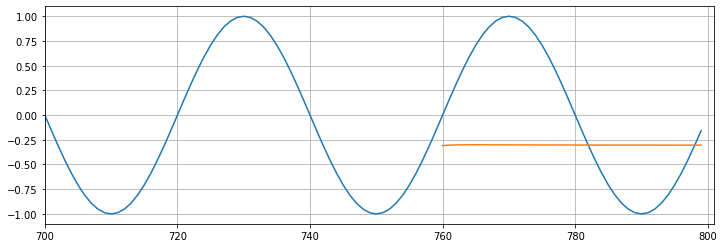

Epoch: 1 - Loss: 0.04972502216696739
Loss: 0.5322929620742798


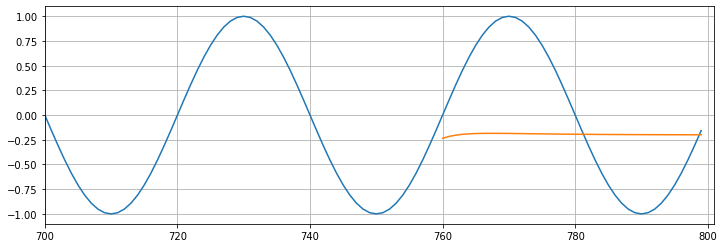

Epoch: 2 - Loss: 0.020234977826476097
Loss: 0.43493539094924927


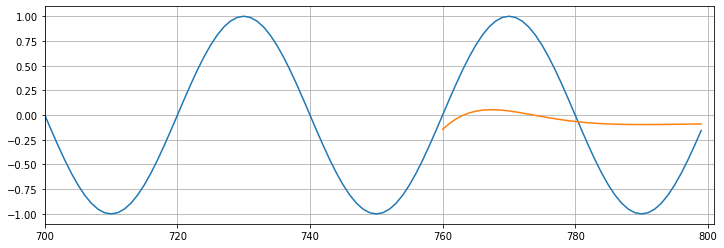

Epoch: 3 - Loss: 0.002637867582961917
Loss: 0.19876213371753693


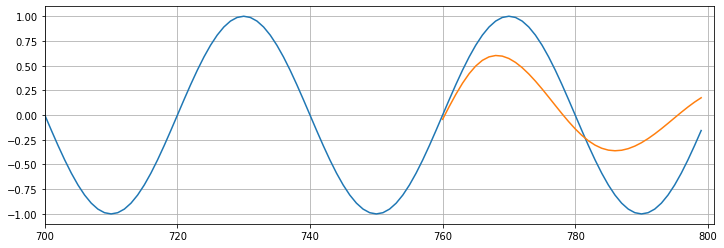

Epoch: 4 - Loss: 0.0001298261631745845
Loss: 0.029951324686408043


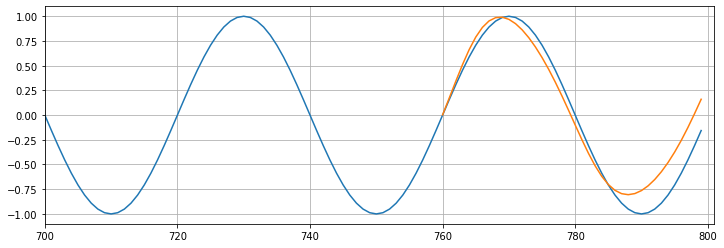

Epoch: 5 - Loss: 1.946820157172624e-05
Loss: 0.00955979060381651


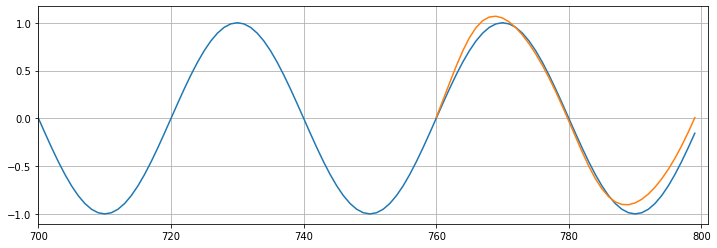

Epoch: 6 - Loss: 1.3684399164048955e-05
Loss: 0.007047393824905157


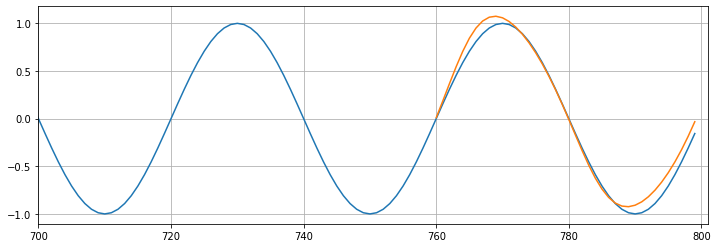

Epoch: 7 - Loss: 1.4154713426250964e-05
Loss: 0.0059882341884076595


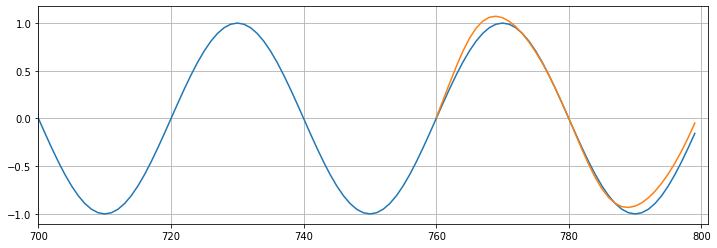

Epoch: 8 - Loss: 1.4943090718588792e-05
Loss: 0.005250047892332077


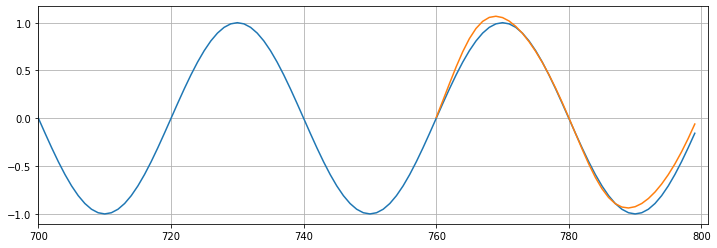

Epoch: 9 - Loss: 1.54311019286979e-05
Loss: 0.004678289871662855


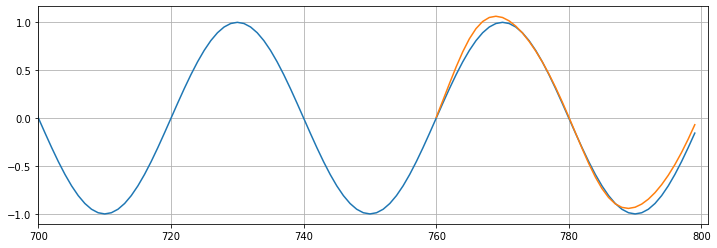

In [24]:
epochs = 10
future = 40

for i in range(epochs):
    
    for seq, y_train in train_data:
        #seq shape:       (40)
        #y_train shape:   (1)
        # Reset the hidden parameters
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                        torch.zeros(1,1,model.hidden_size))
        
        yhat = model(seq) #1. predict
        yhat = yhat.reshape(-1) #I think you don't need this
        loss = criterion(yhat, y_train)#2. loss
            
        optimizer.zero_grad()#3. zero_grad
        loss.backward() #4. backward
        optimizer.step() #5. step
    
    print(f'Epoch: {i} - Loss: {loss}')
    
    #do the test right away here - like validation
    preds = train_set[-window_size:].tolist() #take the last 40 guys 720-760
    
    for _ in range(future):  #looking into the future
        seq = torch.FloatTensor(preds[-window_size:]) # 720-760 | 721-761, ...760-800 
        with torch.no_grad():
            # Reset the hidden parameters
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                            torch.zeros(1,1,model.hidden_size))
            yhat = model(seq)
            preds.append(yhat)
            
    loss = criterion(torch.tensor(preds[-window_size:]), y[760:])
    print(f'Loss: {loss}')
    
    # # Plot from point 700 to the end
    plt.figure(figsize=(12,4))
    plt.xlim(700,801)
    plt.grid(True)
    plt.plot(y)
    plt.plot(np.arange(760,800),torch.tensor(preds[window_size:]))
    plt.show()
        